This notebook serves as a case study for New Yorker.

Maher Nadar.

In [219]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from rich import inspect

from statsmodels.tsa.seasonal import STL


import plotly.express as px

In [201]:
filename = "data/sales.csv"

sales_df = pd.read_csv(filename, index_col="date", parse_dates=["date"])
sales_df = sales_df.sort_index()
print(sales_df.shape)

sales_df.dtypes

(103, 7)


Blouse     int64
Dress      int64
Hoodie     int64
Jacket     int64
Shorts     int64
Skirt      int64
T-shirt    int64
dtype: object

# EDA

In [202]:
# plotly layout:
layout = dict(
    xaxis=dict(
        showgrid=False,
    ),
    yaxis=dict(showgrid=False),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
    width=800,
    height=500,
    title_x=0.5,
)

In [203]:
# check null values:
sales_df.isnull().sum() / len(sales_df)

Blouse     0.0
Dress      0.0
Hoodie     0.0
Jacket     0.0
Shorts     0.0
Skirt      0.0
T-shirt    0.0
dtype: float64

In [204]:
sales_df.index.min(), sales_df.index.max()

(Timestamp('2018-09-27 00:00:00'), Timestamp('2020-09-10 00:00:00'))

In [205]:
# total sales calculation:
sales_df["Total_Sales"] = sales_df.sum(axis=1)

# time-related features:
sales_df = sales_df.eval(
    """
	day_of_week = index.dt.day_of_week
	month = index.dt.month
	year = index.dt.year
	"""
)
sales_df.head()

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt,Total_Sales,day_of_week,month,year
date,,,,,,,,,,,
2018-09-27,19194,21046,12573,10720,3309,9791,26523,103156,3,9,2018
2018-10-04,13292,14721,6916,7645,2557,6981,17594,69706,3,10,2018
2018-10-11,19954,20708,7495,9138,3632,9956,23666,94549,3,10,2018
2018-10-18,17547,20016,7913,9693,3565,7894,20586,87214,3,10,2018
2018-10-25,17420,20397,8887,12132,3415,7495,19395,89141,3,10,2018


In [206]:
sales_df.day_of_week.unique()

array([3], dtype=int32)

In [207]:
sales_df.drop(columns=["day_of_week"], inplace=True)

sales_df.index.diff().value_counts(dropna=False)

date
7 days    102
NaT         1
Name: count, dtype: int64

All the collected values are from Wednesdays.
The data is consistently gathered week by week, as the diff function for the dates shows.

In [208]:
# reshaping the dataframe for plotly:
sales_df_plt = pd.melt(
    frame=sales_df.drop(columns=["month", "year"]).reset_index(),
    id_vars=["date"],
    value_vars=sales_df.columns[:-2],
    value_name="purchase_qty",
    var_name="product",
)

In [209]:
fig = px.line(
    sales_df_plt,
    x="date",
    y="purchase_qty",
    color="product",
    title="Purchased Products evolution",
)

fig.update_layout(**layout)

### months analysis

- groupby [year, month] and sum the puchased items.
- groupby month and average the purchased items for each month.
- compare the months behavior of different products in general.

In [210]:
month_analysis_df = (
    (
        sales_df.groupby(
            ["year", "month"]
        )  # getting the sum of purchased items per year,month.
        .sum()
        .reset_index()
    )
    .drop(columns=["year"])  # getting the average sales per product per month.
    .groupby("month")
    .mean()
).reset_index()

In [211]:
# modify the months df for plotly:
month_analysis_df_plt = pd.melt(
    frame=month_analysis_df,
    id_vars=["month"],
    value_vars=month_analysis_df.columns,
    value_name="purchase_qty",
    var_name="product",
)

In [212]:
fig = px.bar(
    month_analysis_df_plt,
    x="month",
    y="purchase_qty",
    color="product",
    barmode="group",
    title="Average purchased products by month of the year",
)

fig.update_layout(**layout)

### Trend + seasonality

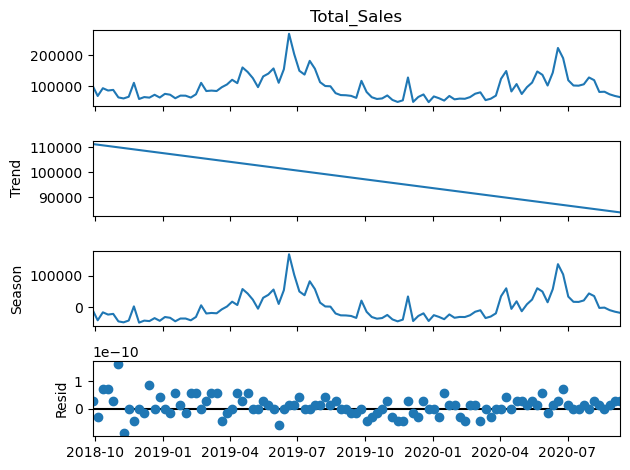

In [213]:
# def time_series_decomposition(data: pd.Series) -> :

stl = STL(sales_df.Total_Sales, seasonal=103)  # Seasonal component assumed to have a 103-week period
result = stl.fit()

# Plot the decomposition
fig = result.plot()
plt.show()

### Correlation between products

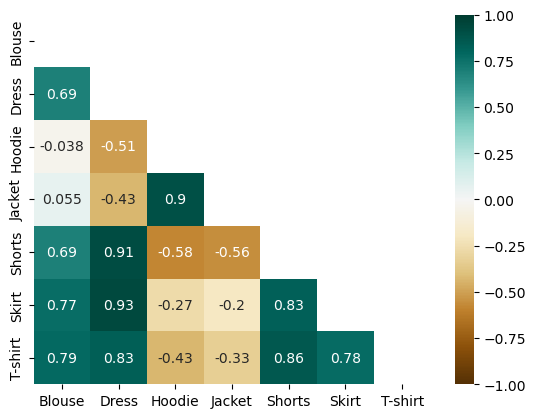

In [225]:
corr_df = sales_df.drop(columns=['year', 'month', 'Total_Sales']).corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')